Import Libraries.

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.svm import SVC
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, precision_recall_fscore_support, classification_report
from sklearn.decomposition import PCA

UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records. 

In [2]:
data = pd.read_csv('heart_failure_database.csv')

Check the distribution of class labels.

In [3]:
data['DEATH_EVENT'].value_counts(normalize=True) * 100

0    67.892977
1    32.107023
Name: DEATH_EVENT, dtype: float64

Separate features and target variable.

The last feature column in the data set is excluded because it is the follow-up period. This feature will of course show a strong relationship to the target label, such as death event, as death is more likely to occur during a longer follow-up. However, it does not make sense to try and learn from this label.

In [4]:
features = data.iloc[:, :-2].to_numpy() 
feature_names = data.columns[:-2].to_numpy()
n_samples, n_features = features.shape
target = data.iloc[:, -1].to_numpy(dtype=bool) 
target_name = data.columns[-1]

Define the training and testing sets. Because of the class imbalance, make sure to have an equal proportion of each class in both sets.

In [5]:
# Use remaining 10% for testing set
test_frac = 0.1 

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_frac, stratify=target)

In [6]:
print('{:.1f}% Positive labels in training set.'.format(y_train.mean() * 100))
print('{:.1f}% Positive labels in testing set.'.format(y_test.mean() * 100))

32.0% Positive labels in training set.
33.3% Positive labels in testing set.


Normalizing features to have zero mean and unit variance.

Some features are binary, and it will do no good to normalize them. Therfore, only apply the normalization to continuous features.

In [7]:
# Detect binary columns
binary_cols = np.zeros((n_features,), dtype=bool)
for i in range(n_features):
    binary_cols[i] = len(np.unique(features[:, i])) == 2
    
# Show which features were detected as binary
print(feature_names[binary_cols]) 

['anaemia' 'diabetes' 'high_blood_pressure' 'sex' 'smoking']


In [8]:
scaler = StandardScaler().fit(X_train[:, ~binary_cols])
X_train[:, ~binary_cols] = scaler.transform(X_train[:, ~binary_cols])
X_test[:, ~binary_cols] = scaler.transform(X_test[:, ~binary_cols])

# Univariate Classification

Predict the class labels using a single feature. Reference the $t$ statistic from Welch's $t$-test to pick the feature with the best separation.

In [9]:
t = np.zeros((n_features,))
for i in range(n_features):
    t[i] = ttest_ind(X_train[y_train, i], X_train[~y_train, i], equal_var=False)[0]
t = np.abs(t) 

print('Feature Ranking:')
ranked_feat_idx = np.flip(np.argsort(t), 0)
for i in ranked_feat_idx:
    print('t={:.1f}\t{}'.format(t[i], feature_names[i]))

Feature Ranking:
t=4.4	ejection_fraction
t=3.8	serum_creatinine
t=3.5	age
t=3.2	serum_sodium
t=1.4	high_blood_pressure
t=1.1	anaemia
t=0.9	creatinine_phosphokinase
t=0.9	platelets
t=0.4	smoking
t=0.3	sex
t=0.0	diabetes


Let's look at the distribution of the best feature for each class.

In [10]:
best_feat_idx = ranked_feat_idx[0]
best_feat = -1 * X_train[:, best_feat_idx]
best_feat_name = feature_names[best_feat_idx]

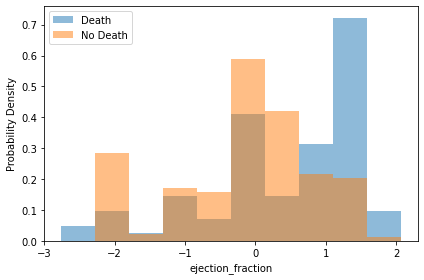

In [11]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bins = np.linspace(best_feat.min(), best_feat.max(), 11)
ax.hist(best_feat[y_train], bins=bins, density=True, alpha=.5, label='Death')
ax.hist(best_feat[~y_train], bins=bins, density=True, alpha=.5, label='No Death')
ax.set_xlabel(best_feat_name)
ax.set_ylabel('Probability Density')
ax.legend()
fig.tight_layout()

Try to separate the two classes using a single threshold. To identify a good treshold, examine the receiver-operator curve (ROC) of the training data, which compares the false and true positive rates of all possible decision boundaries.

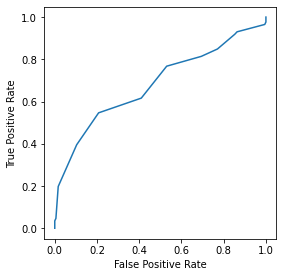

In [12]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
fpr, tpr, thresh = roc_curve(y_train, best_feat)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.axis('square')
fig.tight_layout()

The ROC shows that there is no particularly good boundary using this single feature. Pick the threshold corresponding to the point below if want to emphasize true positives at the expense of many false positives.

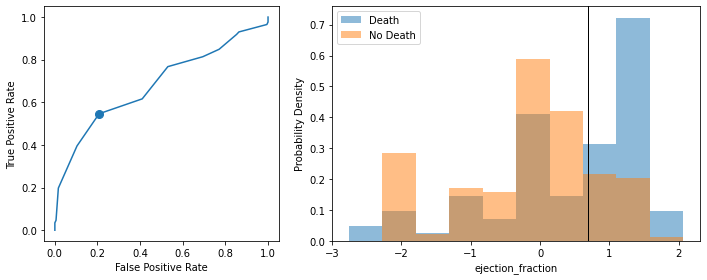

In [13]:
# Corresponds to about a 0.6 true positive rate
selected_idx = 6  
selected_fpr, selected_tpr, selected_thresh = fpr[selected_idx], tpr[selected_idx], thresh[selected_idx]

fig, axs = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'width_ratios': [4, 6]})
ax = axs[0]
ax.plot(fpr, tpr)
ax.scatter(selected_fpr, selected_tpr, s=64)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.axis('square')
ax = axs[1]
ax.hist(best_feat[y_train], bins=bins, density=True, alpha=.5, label='Death')
ax.hist(best_feat[~y_train], bins=bins, density=True, alpha=.5, label='No Death')
ax.axvline(selected_thresh, color='k', linewidth=1)
ax.set_xlabel(best_feat_name)
ax.set_ylabel('Probability Density')
ax.legend()
fig.tight_layout()

To assess the classification performance of this operating point, classify the testing data using the selected threshold.

In [14]:
# Classify test scores using identified threshold
y_hat = (-1*X_test[:, best_feat_idx]) > selected_thresh  

The precision, recall, and F1 score, such as a harmonic mean of precision and recall, are metrics that can summarize performance. The macro average gives equal weight to the performance metric despite the class imbalance. These values look okay so far because the operating point selected emphasizes the identifying true positives.

In [15]:
print(classification_report(y_test, y_hat, target_names=['No Death', 'Death']))

              precision    recall  f1-score   support

    No Death       0.75      0.90      0.82        20
       Death       0.67      0.40      0.50        10

    accuracy                           0.73        30
   macro avg       0.71      0.65      0.66        30
weighted avg       0.72      0.73      0.71        30



Another useful metric is the area under the ROC (AUC), which gives a sense of classifier performance across all possible decision thresholds. Can plot this alongside the ROC for the testing data.

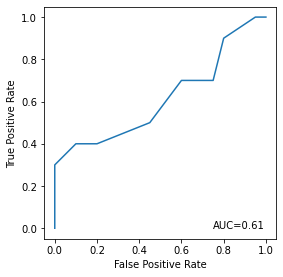

In [16]:
scores = (-1*X_test[:, best_feat_idx]) - selected_thresh
auc = roc_auc_score(y_test, scores, average='macro')
fpr, tpr, _ = roc_curve(y_test, scores)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.text(.75, 0, 'AUC={:.2f}'.format(auc))
ax.axis('square')
fig.tight_layout()

# Multivariate Classification

There might be a better way to perform classification by using multiple features. The plot showed that the best feature did not well-seperate the data on its own. Try to look at class distribution using the two best features, and to visualize the separation between the classes by using Principal Component Analysis (PCA) to reduce the dimensionality of the features.

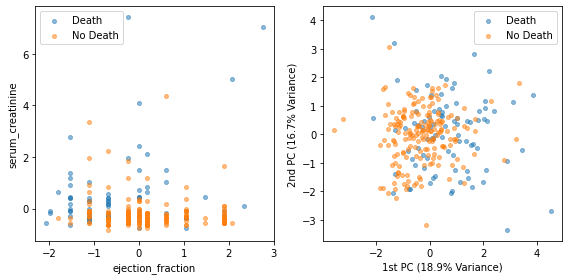

In [17]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 2, 1)
idx1, idx2 = ranked_feat_idx[:2]
ax.scatter(X_train[y_train, idx1], X_train[y_train, idx2], label='Death', s=16, alpha=0.5)
ax.scatter(X_train[~y_train, idx1], X_train[~y_train, idx2], label='No Death', s=16, alpha=0.5)
ax.legend()
ax.set_xlabel(feature_names[idx1])
ax.set_ylabel(feature_names[idx2])

ax = fig.add_subplot(1, 2, 2)
pca = PCA(n_components=2).fit(X_train)
X_train_pca = pca.transform(X_train)
ax.scatter(*X_train_pca[y_train].T, label='Death', s=16, alpha=0.5)
ax.scatter(*X_train_pca[~y_train].T, label='No Death', s=16, alpha=0.5)
ax.legend()
ax.set_xlabel('1st PC ({:.1f}% Variance)'.format(pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('2nd PC ({:.1f}% Variance)'.format(pca.explained_variance_ratio_[1] * 100))

fig.tight_layout()

Though some separation is visible, there is no clear boundary. However, the PCA transformation captures less than 40% of the variance in the data, so that is the reason why not seeing a comprehensive picture.

Regardless, try to use a logistic regression model to take advantage of the higher-dimensional space and separate the classes. Logistic regression has a regularization hyperparameter, $C$, that needs to be chosen. Select this hyperparameter using 5-fold cross-validation in the training data.

In [18]:
# Dictionary of model hyperparameters we want to select and their possible values
params = {  
    'C': np.logspace(-4, 4, 401)
}

cv_result = GridSearchCV(
    # The model to validate
    LogisticRegression(),  
    # The parameters to validate and their possible values
    params,  
    # The score to optimize
    scoring='f1_macro',  
    # Use all available processors
    n_jobs=-1,  
     # Stratified 5-fold CV
    cv=5 
).fit(X_train, y_train)
print('The selected value of C was: {C:.2e}'.format(**cv_result.best_params_))

# Train a model using the selected hyperparameter
model = LogisticRegression(**cv_result.best_params_).fit(X_train, y_train)

The selected value of C was: 1.45e+00


In [19]:
# A function to show the classification performance
def classify_perf(y_true, y_hat, scores):
    print(classification_report(y_true, y_hat, target_names=['No Death', 'Death']))
    
    auc = roc_auc_score(y_true, scores, average='macro')
    fpr, tpr, _ = roc_curve(y_true, scores)
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.text(.75, 0, 'AUC={:.2f}'.format(auc))
    ax.axis('square')
    fig.tight_layout()

              precision    recall  f1-score   support

    No Death       0.79      0.95      0.86        20
       Death       0.83      0.50      0.62        10

    accuracy                           0.80        30
   macro avg       0.81      0.72      0.74        30
weighted avg       0.81      0.80      0.78        30



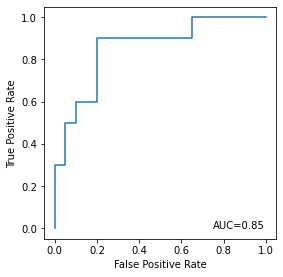

In [20]:
# Evaluate model performance
y_hat = model.predict(X_test)
scores = model.predict_proba(X_test)[:, 1]
classify_perf(y_test, y_hat, scores)

If look at the classification performance of the model trained all all features, it looks much better. 
The AUC, in particular, has vastly improved.

## Random Forest Classification

              precision    recall  f1-score   support

    No Death       0.86      0.90      0.88        20
       Death       0.78      0.70      0.74        10

    accuracy                           0.83        30
   macro avg       0.82      0.80      0.81        30
weighted avg       0.83      0.83      0.83        30



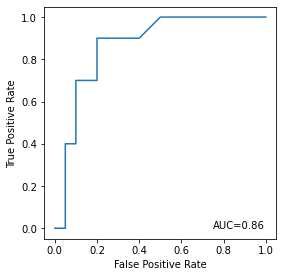

In [21]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1).fit(X_train, y_train)
y_hat = model.predict(X_test)
scores = model.predict_proba(X_test)[:, 1]
classify_perf(y_test, y_hat, scores)

## Gaussian Process Classification

              precision    recall  f1-score   support

    No Death       0.78      0.90      0.84        20
       Death       0.71      0.50      0.59        10

    accuracy                           0.77        30
   macro avg       0.75      0.70      0.71        30
weighted avg       0.76      0.77      0.75        30



/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


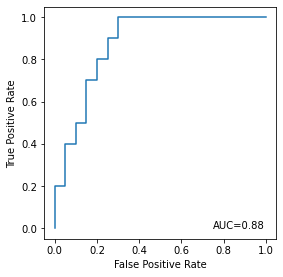

In [22]:
kernel = 1 * RBF() + WhiteKernel()
model = GaussianProcessClassifier(kernel=kernel).fit(X_train, y_train)
y_hat = model.predict(X_test)
scores = model.predict_proba(X_test)[:, 1]
classify_perf(y_test, y_hat, scores)

## Support Vector Classification (RBF Kernel)

Selected Hyperparameters:
 -     C = 1.00e+04
 - gamma = 2.51e-04

              precision    recall  f1-score   support

    No Death       0.75      0.90      0.82        20
       Death       0.67      0.40      0.50        10

    accuracy                           0.73        30
   macro avg       0.71      0.65      0.66        30
weighted avg       0.72      0.73      0.71        30



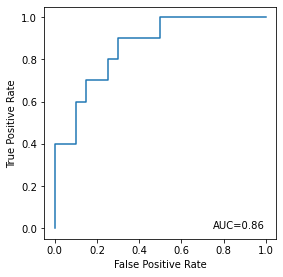

In [23]:
params = {  
    'C': np.logspace(-4, 4, 21),
    'gamma': np.logspace(-4, 4, 21),
}

cv_result = GridSearchCV(
    SVC(),  
    params,  
    scoring='f1_macro',  
    n_jobs=-1, 
    cv=5 
).fit(X_train, y_train)

print('Selected Hyperparameters:')
for k, v in cv_result.best_params_.items():
    print(' - {:>5s} = {:.2e}'.format(k, v))
print()

# Train a model using the selected hyperparameters
model = SVC(**cv_result.best_params_, probability=True).fit(X_train, y_train)

# Evaluate the model
y_hat = model.predict(X_test)
scores = model.predict_proba(X_test)[:, 1]
classify_perf(y_test, y_hat, scores)